In [1]:
import pandas as pd
import numpy as np
import feather
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
np.__version__, pd.__version__

('1.13.1', '0.20.3')

In [3]:
digits = feather.read_dataframe('digits-train.feather')

In [4]:
labels = feather.read_dataframe('digits-train-labels.feather')

In [5]:
img = digits.loc[0, :].copy().values.reshape((28,28))

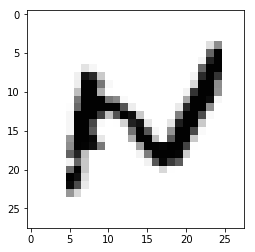

In [6]:
plt.imshow(img, cmap = 'Greys')
#All images must be turned 90 degrees clockwise to be human readable

In [7]:
def choose_digits(digits, labels, digit_list) :
    data = pd.concat([digits, labels], axis = 1)
    data = data.loc[data.label.isin(digit_list), :]
    data.drop('label', axis = 1, inplace = True)
    return data.values

In [18]:
def choose_labels(labels, decision_label, digit_list) :
    data = labels.loc[labels.label.isin(digit_list), :].values
    n = data.shape[0]
    data = data.reshape(n,)
    data = np.where(data == decision_label, 1, -1)
    return data

In [10]:
digits_0_1 = choose_digits(digits, labels, [0,1])

In [19]:
labels_0_1 = choose_labels(labels, 0, [0,1])

In [21]:
def distances(training, test) :
    x = training - test
    y = np.dot(x, x.T)
    return np.diagonal(y)

In [40]:
def predict(training, test, labels) :
    
    dist = distances(training, test)
    idx = np.argsort(dist)
    labels = labels[idx]
    predictions = np.sign(np.cumsum(labels))
    
    return predictions
    

In [42]:
predictions = predict(digits_0_1, digits_0_1[0], labels_0_1)

In [48]:
predictions[0:33]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
# Make funktion that runs through the test examples 
# and for each of them constructs the prediction from the training 
# set for each k (one row for each test example, one column for each k)